# 前言
我们使用利用概率模型建立一个卷积神经网络来实现概率推理。这次要做的是：
建立一个贝叶斯卷积神经网络来预测 mnist(手写数据集) 的分类。

参考：https://github.com/tensorflow/probability/tree/v0.17.0/tensorflow_probability/examples/models
这里是 VGG 或是 Resnet 的概率模型实现。

用到的库

In [21]:
import tensorflow as tf
import tensorflow_probability as tfp
from keras.utils.vis_utils import plot_model
import os
from keras.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ssl
ssl._create_default_https_context = ssl._create_unverified_context # 解决 [SSL: CERTIFICATE_VERIFY_FAILED] 问题
tfd = tfp.distributions

# 训练和测试数据获取
keras 自带的mnist数据集，需要等它下载完

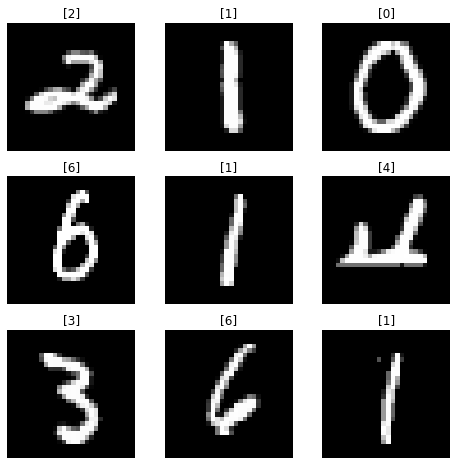

In [11]:
#==== 训练和测试数据获取
train_set, val_set = tf.keras.datasets.mnist.load_data()
x_tra , y_tra = train_set[0],tf.keras.utils.to_categorical(train_set[1])# 变为one-hot编码
x_val , y_val = val_set[0],tf.keras.utils.to_categorical(val_set[1]) # 评估集

#==== 用于显示部分数据的展示
def Data_checker():
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        figure.add_subplot(rows, cols, i)
        sample_idx = np.random.randint(len(x_tra), size=1)
        img, label = x_tra[sample_idx],train_set[1][sample_idx]
        plt.title(str(label))
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()
Data_checker()

# 概率网络模型

贝叶斯网络的损失函数一般为Evidence Lower Bound Loss (ELBO)。

建立一个由Convolution2DFlipout和DenseFlipout层构成的网络，损失函数使用 cross entropy，使用Flipout时,
Keras API 会自动将KL散度加在cross entropy loss上，其实等价于计算(negated) ELBO。

下面是一个分类模型，输入为shape = [28, 28, 1]的手写图片，输出为10维的one-hot编码(代表0-9)

In [12]:
def Bayesian_CNN():
  # 初始化权重w的后验，服从正态 N(mean,std)
  kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn(
      untransformed_scale_initializer=tf.compat.v1.initializers.random_normal(
          mean=-9.0,
          stddev=0.1),)#
  
  NUM_TRAIN_EXAMPLES = len(x_tra) #训练数据数目
  # 归一化KL散度，免得其过大
  kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p)/tf.cast(NUM_TRAIN_EXAMPLES, dtype=tf.float32))#KL散度/样本数目

  Inpt = tf.keras.layers.Input(shape=[28, 28, 1])
  x = tfp.layers.Convolution2DFlipout(16, kernel_size=5,strides=1, padding='SAME',kernel_posterior_fn=kernel_posterior_fn, activation='relu',kernel_divergence_fn=kl_divergence_function,)(Inpt) # 
  x = tf.keras.layers.MaxPooling2D(pool_size=[2, 2],strides=[2, 2],padding='SAME')(x)
  x = tfp.layers.Convolution2DFlipout(32, kernel_size=5,strides=1, padding='SAME',kernel_posterior_fn=kernel_posterior_fn,activation='relu', kernel_divergence_fn=kl_divergence_function,)(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=[2, 2],strides=[2, 2],padding='SAME')(x)
  x = tfp.layers.Convolution2DFlipout(64, kernel_size=5,strides=1, padding='SAME',kernel_posterior_fn=kernel_posterior_fn, activation='relu',kernel_divergence_fn=kl_divergence_function,)(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=[2, 2],strides=[2, 2],padding='SAME')(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.AveragePooling2D(4, 1)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tfp.layers.DenseFlipout(10,activation='softmax',kernel_posterior_fn=kernel_posterior_fn, kernel_divergence_fn=kl_divergence_function,)(x)
  model = tf.keras.Model(inputs=Inpt, outputs=x, name='BNN_classify')
  return model

# 设定loss和各项超参数
# Note: We use the categorical_crossentropy loss since the MNIST dataset contains ten labels. The Keras API will then automatically add the Kullback-Leibler divergence (contained on the individual layers of the model), to the cross entropy loss, effectively calcuating the (negated) Evidence Lower Bound Loss (ELBO).

In [13]:
model = Bayesian_CNN() #实例化
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3) # Adam优化器 学习率0.001
loss = 'categorical_crossentropy'
  # We use the categorical_crossentropy loss since the MNIST dataset contains
  # ten labels. The Keras API will then automatically add the
  # Kullback-Leibler divergence (contained on the individual layers of
  # the model), to the cross entropy loss, effectively
  # calcuating the (negated) Evidence Lower Bound Loss (ELBO)
model.compile(optimizer,loss=loss,metrics='acc') 
plot_model(model,to_file=os.path.join('./fig',model.name+'_dataflow.pdf'),show_shapes=True,show_layer_names=False) # 绘制模型结构

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
2022-07-25 17:57:01.097134: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


# 训练模型

epoch, batch_size = 5, 128
保存最好的模型，可连续训练

In [14]:
epoch, batch_size = 5, 128
if os.path.exists(model.name+'.h5'):# 读取存在的模型继续训练
  model.load_weights(model.name+'.h5')
checkpoint = ModelCheckpoint(model.name+'.h5', monitor='val_acc',save_weights_only=True,verbose=1,save_best_only=True)# 仅保存最好的模型
history = model.fit(x_tra,y_tra, epochs=epoch,batch_size=batch_size, validation_data=(x_val,y_val),callbacks=[checkpoint],shuffle=False) # 训练

Epoch 1/5
469/469 [==============================] - ETA: 0s - loss: 10.8503 - acc: 0.8082
Epoch 1: val_acc improved from -inf to 0.91780, saving model to BNN_classify.h5
469/469 [==============================] - 61s 125ms/step - loss: 10.8503 - acc: 0.8082 - val_loss: 9.0782 - val_acc: 0.9178
Epoch 2/5
469/469 [==============================] - ETA: 0s - loss: 8.7124 - acc: 0.9494
Epoch 2: val_acc improved from 0.91780 to 0.95620, saving model to BNN_classify.h5
469/469 [==============================] - 68s 146ms/step - loss: 8.7124 - acc: 0.9494 - val_loss: 8.4401 - val_acc: 0.9562
Epoch 3/5
469/469 [==============================] - ETA: 0s - loss: 8.1637 - acc: 0.9678
Epoch 3: val_acc improved from 0.95620 to 0.96540, saving model to BNN_classify.h5
469/469 [==============================] - 64s 137ms/step - loss: 8.1637 - acc: 0.9678 - val_loss: 7.9240 - val_acc: 0.9654
Epoch 4/5
469/469 [==============================] - ETA: 0s - loss: 7.6452 - acc: 0.9771
Epoch 4: val_acc imp

# 预测

此模型只能捕获到 Epistemic Uncertainty，因为网络参数服从分布但是输出并没有设定为一个分布函数的形式。

我们在评估集中随便选取一张图片预测多次结果，观测其Epistemic Uncertainty。

4/4 [==============================] - 0s 11ms/step
pred_mean: 0.9999998 
 pred_std: 4.7758164e-07


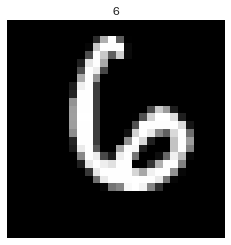

In [54]:
#=== 预测x_val的第0个数据5次，并打印5次预测的结果和真实值
i = 88 #第i个图
xi,yi = val_set[0][i],val_set[1][i]
img, label = xi,yi
plt.title(str(label))
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray")
#采样100次，得到100个不同的预测值
xi = np.array([xi for _ in range(100)])
pred = model.predict(xi)
#print(pred,'\n','ture:',yi)
mean = sum(pred)/len(pred)
stddev = np.std(pred,axis=0)
print('pred_mean:',mean[yi],'\n','pred_std:',stddev[yi])